In [1]:
# Importing libraries
import numpy as np
import cv2
from skimage import io

# Normal cv2.imshow() doesn't work in Google Colab, we need to use 
# the cv2_imshow() function to display images
from google.colab.patches import cv2_imshow

In [2]:
# (Assigned to Hamna and Uswa)

# Create a function that takes as parameter a grayscale image and energy map
# and returns a modified energy map with highlighted faces to preserve them
# when seam carving takes place

# Parameters: Image => 2D Matrix, Energy Map => 2D Matrix
# Return Value: Modified Energy Map => 2D Matrix

def _preserve_faces(grayscale_image, energy_map):
    # Detect faces in the image
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(grayscale_image, 1.3, 5)
    
    # Find the max value from the energy_map
    max_energy = np.max(energy_map)
    
    # Preserve faces by setting their energy to the maximum
    for (x, y, w, h) in faces:
        energy_map[y:y+h, x:x+w] = max_energy
        
    return energy_map

In [3]:
# (Assigned to Hammad)

# Create a function that takes in an image, and returns an energy map of the image

# Paramters: Image => 2D Matrix
# Return Value: Energy Map => 2D Matrix

def get_energy_map(grayscale_image, preserve_faces=False):
  # Applying sobel filter to find the gradients
  sobel_x = np.array([
      [1, 0, -1],
      [2, 0, -2],
      [1, 0, -1]
  ])

  sobel_y = np.array([
      [1, 2, 1],
      [0, 0, 0],
      [-1, -2, -1]
  ])

  from math import sqrt

  # Calculate the energy to map to use for locating seam paths
  energy_map_x = cv2.filter2D(grayscale_image, 0, sobel_x)
  energy_map_y = cv2.filter2D(grayscale_image, 0, sobel_y)

  energy_map = np.zeros(grayscale_image.shape)

  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      energy_map[i][j] = sqrt((energy_map_x[i][j] ** 2) + (energy_map_y[i][j] ** 2))

  if preserve_faces:
    _preserve_faces(grayscale_image, energy_map)
  
  return energy_map

In [4]:
# Helper function in vertical seam path

# Create a function that takes as paramter energy map and column to find calculate seam path

memo = {}

def calculate_seam_cost(energy_map, row, col):
  global memo

  if (row, col) in memo:
    return memo[(row, col)]

  if row >= (energy_map.shape[0] - 1):
    return energy_map[row][col]

  # Find the path by tracking the minimum
  if col == 0:
    cost = min(calculate_seam_cost(energy_map, row + 1, col + 1),
               calculate_seam_cost(energy_map, row + 1, col))

  elif col == energy_map.shape[1] - 1:
    cost = min(calculate_seam_cost(energy_map, row + 1, col),
                calculate_seam_cost(energy_map, row + 1, col - 1))

  else:
    cost = min(calculate_seam_cost(energy_map, row + 1, col), 
               calculate_seam_cost(energy_map, row + 1, col - 1),
               calculate_seam_cost(energy_map, row + 1, col + 1))

  memo[(row, col)] = energy_map[row][col] + cost
  return energy_map[row][col] + cost

In [5]:
# Helper function in vertical seam path

# Create a function that takes as paramter the column index and returns a seam
# path starting from that column index

path_memo = {}

def _get_seam_path(energy_map, row, col):
  global path_memo

  if (row, col) in path_memo:
    return path_memo[(row, col)]

  if row >= (energy_map.shape[0] - 1):
    path_memo[(row, col)] = (energy_map[row][col], [(row, col)])
    return (energy_map[row][col], [(row, col)])

  # Find the path by tracking the minimum
  if col == 0:
    right, right_path = _get_seam_path(energy_map, row + 1, col + 1)
    below, below_path =  _get_seam_path(energy_map, row + 1, col)
    cost = min(right, below)

    if right < below:
      path = right_path
    else:
      path = below_path

  elif col == energy_map.shape[1] - 1:
    below, below_path = _get_seam_path(energy_map, row + 1, col)
    left, left_path = _get_seam_path(energy_map, row + 1, col - 1)
    cost = min(below,left)
    

    if left < below:
      path = left_path
    else:
      path = below_path

  else:
    left, left_path = _get_seam_path(energy_map, row + 1, col - 1)
    right, right_path = _get_seam_path(energy_map, row + 1, col + 1)
    below, below_path = _get_seam_path(energy_map, row + 1, col)
    cost = min(left, right, below)

    if right > left < below:
      path = left_path
    elif left > right < below:
      path = right_path
    else:
      path = below_path

  path_memo[(row, col)] = (energy_map[row][col] + cost, path + [(row, col)])
  return (energy_map[row][col] + cost, path + [(row, col)])

def get_seam_path(energy_map, row, col):
  global path_memo
  path = _get_seam_path(energy_map, row, col)[1]
  return path

In [6]:
# (Assigned to Hammad)
# Create a function that takes input an energy map and creates a 
# array of points(x and y indexes) of a vertical seam

# Parameters: Energy Map => 2D Matrix
# Return Value: Vertical Seam Path => Array of tuples

def vertical_seam_path(energy_map):
  global memo
  global path_memo

  memo = {}
  path_memo = {}

  cols = energy_map.shape[1]

  min_cost = calculate_seam_cost(energy_map, 0, 0)
  min_col_index = 0

  for j in range(1, cols):
    cost = calculate_seam_cost(energy_map, 0, j)
    if min_cost > cost:
      min_cost = cost
      min_col_index = j

  return get_seam_path(energy_map, 0, min_col_index)

In [7]:
# (Assigned to Hamna)
# Create a function that input the image and the seam path
# and creates an enlarged version of the image

# Parameters: Energy Map => 2D Matrix, Seam Path => Array of Tuples,
#               Count => Columns to add
# Return Value: Resized Image Matrix => 2D Matrix

def add_seam(image, path):
    if (len(image.shape) == 3):
      resized_image = np.zeros((image.shape[0], image.shape[1]+1, image.shape[2]))
    else:
      resized_image = np.zeros((image.shape[0], image.shape[1]+1))
    for i in range(image.shape[0]):
        j_offset = 0
        for j in range(image.shape[1]):
            if (i, j) in path:
                resized_image[i, j+j_offset:j+j_offset+2] = image[i, j]
                j_offset += 1
            else:
                resized_image[i, j+j_offset] = image[i, j]
        
    return resized_image

In [8]:
# (Assigned to Uswa)
# Create a function that takes input the image and the seam path
# and removes it from the image

# Parameters: Energy Map => 2D Matrix, Seam Path => Array of Tuples,
#              Count => Columns to remove
# Return Value: Resized Image Matrix => 2D Matrix

def remove_seam(image, path):
    # Create the resized image matrix
    if (len(image.shape) == 3):
      resized_image = np.zeros((image.shape[0], image.shape[1]-1, image.shape[2]))
    else:
      resized_image = np.zeros((image.shape[0], image.shape[1]-1))

    # Loop through each row in the image
    for j in range(image.shape[0]):
        l = 0
        # Loop through each pixel in the row
        for i in range(image.shape[1]):
            # If the pixel isn't in the seam path, copy it to the resized image
            if (j, i) not in path:
                if (len(image.shape) == 3):
                  resized_image[j, l, :] = image[j,i, :]
                else:
                  resized_image[j, l] = image[j,i]
                l += 1

    return resized_image

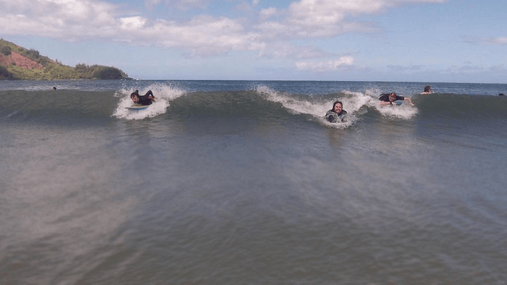

In [9]:
# Taking image as input
# image_path = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Broadway_tower_edit.jpg/1024px-Broadway_tower_edit.jpg"
image_path = "https://courses.cs.washington.edu/courses/cse373/20wi/assets/images/seamcarving/HJoceanSmall.png"
# image_path = "https://img0.etsystatic.com/028/0/6631197/il_75x75.539282654_o60u.jpg"
image = io.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

cv2_imshow(image)

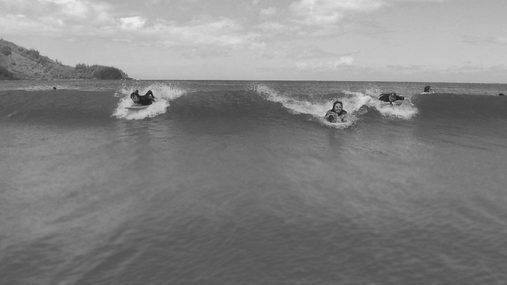

In [10]:
grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
cv2_imshow(grayscale_image)

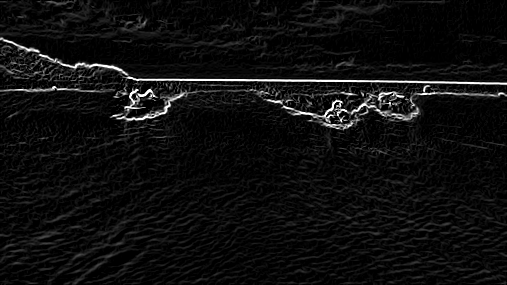

In [11]:
energy_map = get_energy_map(grayscale_image)
cv2_imshow(energy_map)

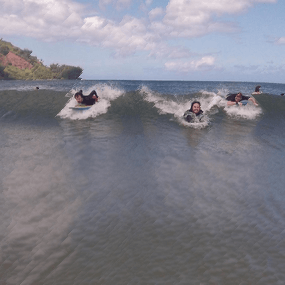

In [12]:
temp_image = image
temp_energy_map = energy_map

# Run a loop to remove 222 seams from the image

seam_removed = []

# Removing 222 seams from the image
for _ in range(222):
  seam = vertical_seam_path(temp_energy_map)
  seam_removed.append(seam)
  temp_energy_map = remove_seam(temp_energy_map, seam)
  temp_image = remove_seam(temp_image, seam)

cv2_imshow(temp_image)

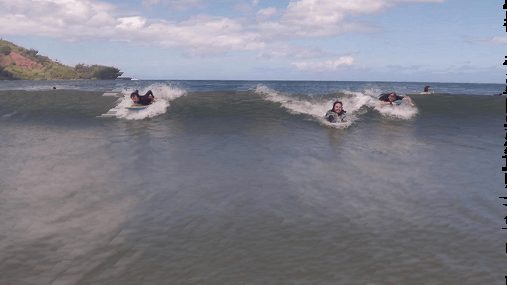

In [13]:
seam_removed.reverse()

# Adding back the 222 columns into the image
for seam in seam_removed:
  temp_image = add_seam(temp_image, seam)

cv2_imshow(temp_image)

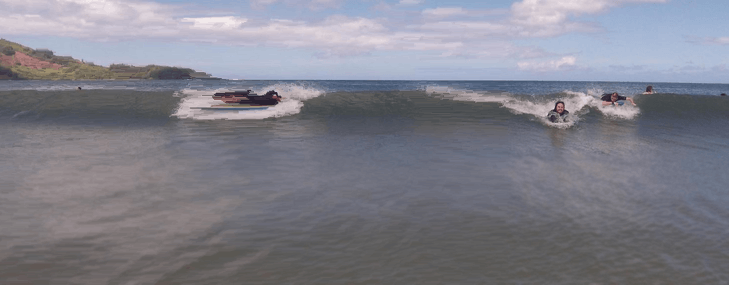

In [14]:
# Enlarging the original image

for seam in seam_removed:
  image = add_seam(image, seam)

cv2_imshow(image)

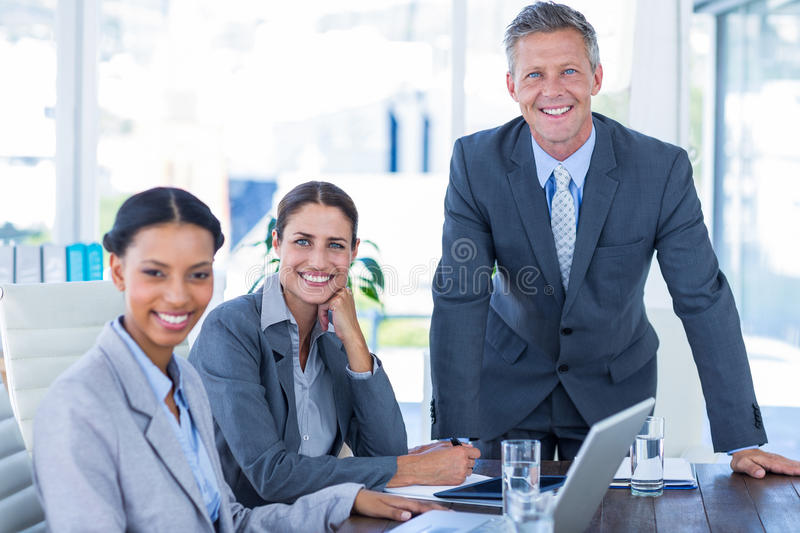

In [15]:
# Reducing the height of an image

image_path = "https://thumbs.dreamstime.com/b/business-people-looking-camera-office-56481104.jpg"
image = io.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2_imshow(image)

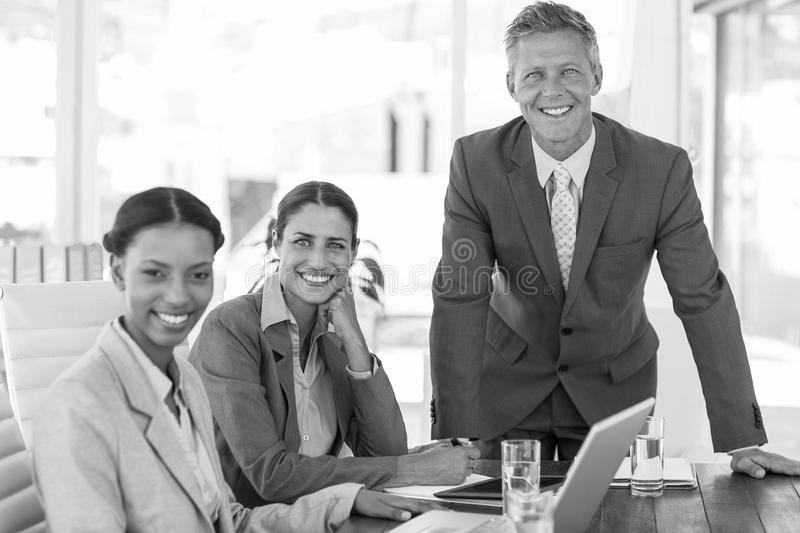

In [16]:
grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
cv2_imshow(grayscale_image)

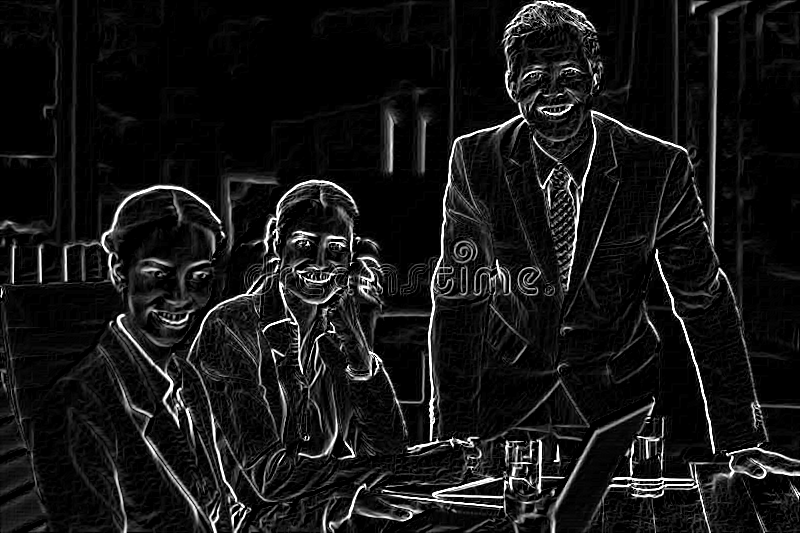

In [17]:
energy_map = get_energy_map(grayscale_image, False)
cv2_imshow(energy_map)

In [ ]:
# Removing rows to reduce height

# We flip the image and repeat the process above

rotated_image = np.rot90(image)
rotated_energy_map = np.rot90(energy_map)




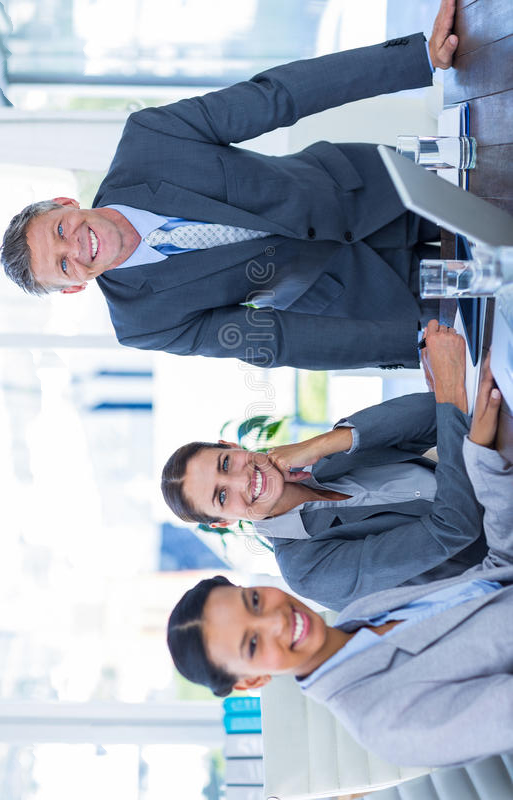

In [19]:

# Removing 20 seams from the image
for _ in range(20):
  seam = vertical_seam_path(rotated_energy_map)
  seam_removed.append(seam)
  rotated_energy_map = remove_seam(rotated_energy_map, seam)
  rotated_image = remove_seam(rotated_image, seam)

cv2_imshow(rotated_image)

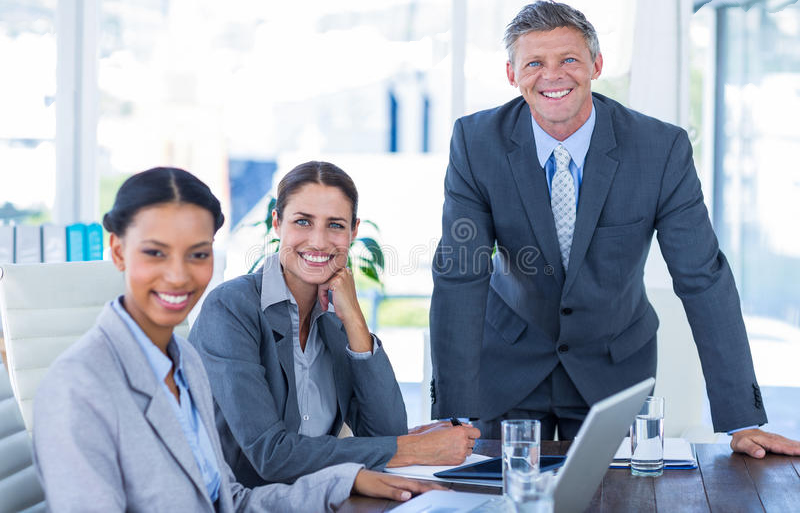

In [20]:
rotated_image = np.rot90(rotated_image, 3)
cv2_imshow(rotated_image)

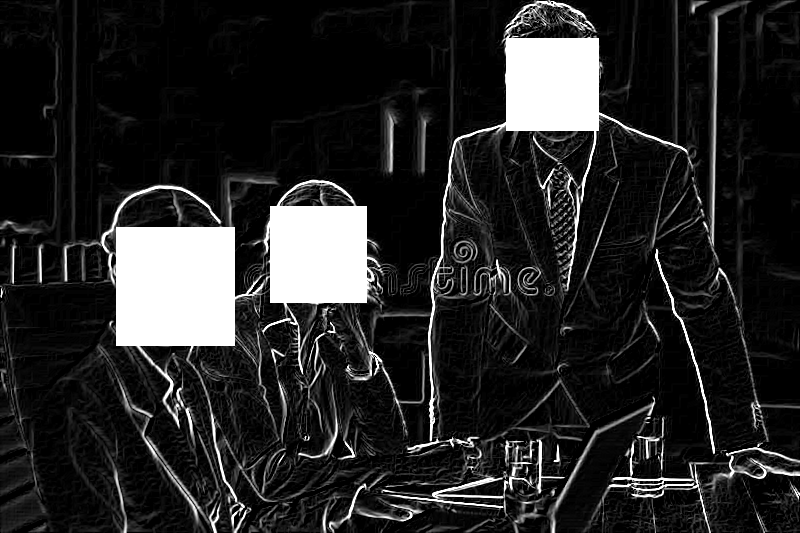

In [21]:
# Now performing the same operation to the above image, but preserving faces

image_path = "https://thumbs.dreamstime.com/b/business-people-looking-camera-office-56481104.jpg"
image = io.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

energy_map = get_energy_map(grayscale_image, True)

cv2_imshow(energy_map)

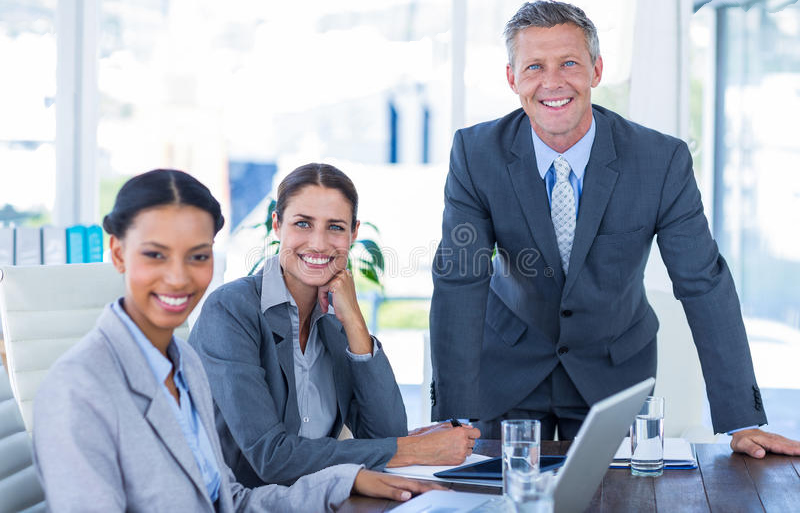

In [22]:
rotated_image = np.rot90(image)
rotated_energy_map = np.rot90(energy_map)

for _ in range(20):
  seam = vertical_seam_path(rotated_energy_map)
  seam_removed.append(seam)
  rotated_energy_map = remove_seam(rotated_energy_map, seam)
  rotated_image = remove_seam(rotated_image, seam)

cv2_imshow(np.rot90(rotated_image, 3))